# 🔍 Random Forest for Vulnerability Detection

This notebook uses Random Forest on the DiverseVul dataset (TF-IDF features)

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [ ]:
import json

# Loading the JSON file
file_path = "...diversevul_20230702.json"       # TODO: Update this path before running

# Load JSONL format line by line
data = []
with open(file_path, "r", encoding="utf-8") as f:
    for line in f:
        data.append(json.loads(line))

# Inspect dataset quickly 
df = pd.DataFrame(data)
df.head()

,func,target,cwe,project,commit_id,hash,size,message
0,int _gnutls_ciphertext2compressed(gnutls_sessi...,1,[],gnutls,7ad6162573ba79a4392c63b453ad0220ca6c5ace,73008646937836648589283922871188272089,157,added an extra check while checking the padding.
1,static char *make_filename_safe(const char *fi...,1,[CWE-264],php-src,055ecbc62878e86287d742c7246c21606cee8183,211824207069112513181516095447837228041,22,Improve check for :memory: pseudo-filename in ...
2,"unpack_Z_stream(int fd_in, int fd_out)\n{\n\tI...",1,[],busybox,251fc70e9722f931eec23a34030d05ba5f747b0e,21401706257394042943815500829552774160,232,uncompress: fix buffer underrun by corrupted i...
3,"static void cirrus_do_copy(CirrusVGAState *s, ...",1,[CWE-787],qemu,b2eb849d4b1fdb6f35d5c46958c7f703cf64cfef,135590882627853658533498335902319684573,66,"CVE-2007-1320 - Cirrus LGD-54XX ""bitblt"" heap ..."
4,"glue(cirrus_bitblt_rop_fwd_, ROP_NAME)(CirrusV...",1,[CWE-787],qemu,b2eb849d4b1fdb6f35d5c46958c7f703cf64cfef,27696392987383562433164405181263025184,18,"CVE-2007-1320 - Cirrus LGD-54XX ""bitblt"" heap ..."


In [ ]:
# Due to GPU contstraints of my PC, running the model on 100k samples. Feel free to adjust the samples based on GPU power available.
# Sample balanced dataset (85K safe, 15K vulnerable)

safe_df = df[df['target'] == 0].sample(85000, random_state=42)
vuln_df = df[df['target'] == 1].sample(15000, random_state=42)
df_100k = pd.concat([safe_df, vuln_df]).sample(frac=1, random_state=42)

texts = df_100k['func'].tolist()
labels = df_100k['target'].tolist()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# TF-IDF Vectorization
X = TfidfVectorizer().fit_transform(texts)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, labels, test_size=0.2, random_state=42, stratify=labels
)

# Train Random Forest model
clf = RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1)
clf.fit(X_train, y_train)

# Evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.87      0.96      0.91     17000
           1       0.48      0.19      0.27      3000

    accuracy                           0.85     20000
   macro avg       0.67      0.58      0.59     20000
weighted avg       0.81      0.85      0.82     20000



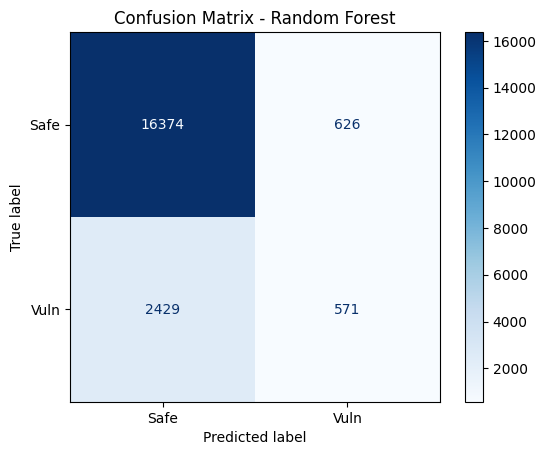

In [5]:
# Confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, display_labels=["Safe", "Vuln"], cmap='Blues')
plt.title("Confusion Matrix - Random Forest")
plt.show()

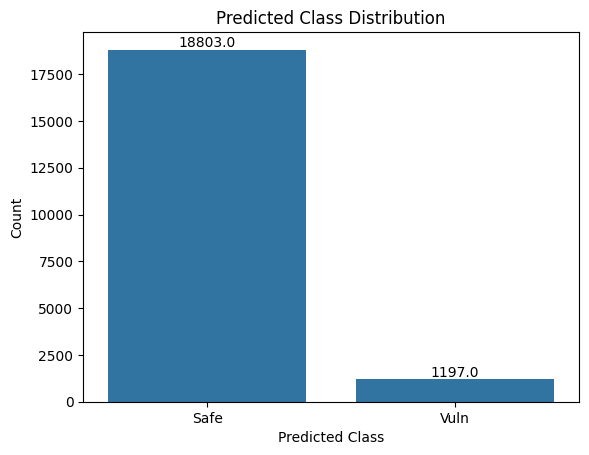

In [ ]:
# Plotting graphs to showcase the results of the RF run.
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

ax=sns.countplot(x=y_pred)
plt.title("Predicted Class Distribution")
plt.xlabel("Predicted Class")
plt.ylabel("Count")
plt.xticks([0, 1], ["Safe", "Vuln"])

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom')

plt.show()

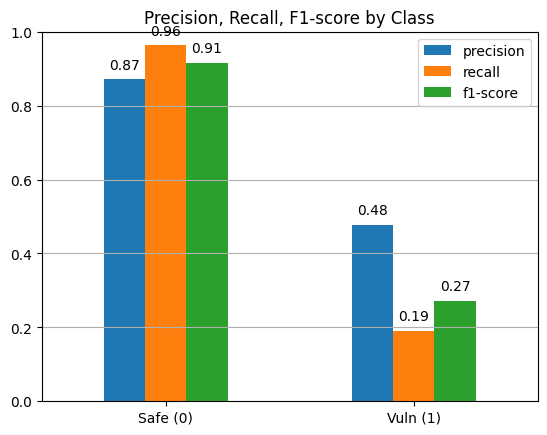

In [ ]:
# Plotting graphs to showcase the results of the RF run.

from sklearn.metrics import classification_report
import pandas as pd
import matplotlib.pyplot as plt

# Generate report and extract class 0 and 1
report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()
metrics = df_report.loc[["0", "1"], ["precision", "recall", "f1-score"]]

# Plot
ax = metrics.plot(kind='bar')
plt.title("Precision, Recall, F1-score by Class")
plt.xticks([0, 1], ["Safe (0)", "Vuln (1)"], rotation=0)
plt.ylim(0, 1)
plt.grid(axis='y')

# Add values on bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height() + 0.02),
                ha='center', va='bottom')

plt.show()
